In [73]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['val', 'submission.csv', '__notebook_source__.ipynb', '__MACOSX', 'train', '.ipynb_checkpoints', 'plates']


In [74]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['test', '.DS_Store', 'train']


In [75]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))


100%|██████████| 21/21 [00:00<00:00, 2823.18it/s]

In [65]:
!ls train

cleaned  dirty


In [76]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ColorJitter(0.6, 0.6, 0.6, 0.3),
    #torchvision.transforms.RandomGrayscale(p=0.1),
    torchvision.transforms.RandomRotation(360),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [77]:
len(train_dataloader), len(train_dataset)

(4, 32)

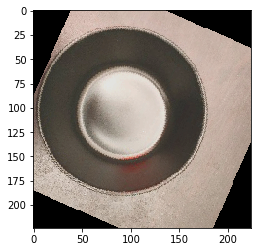

In [78]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

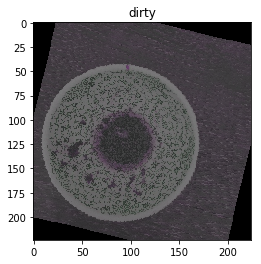

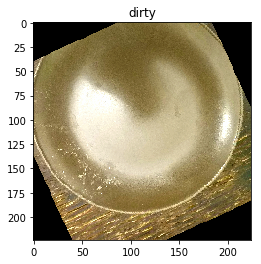

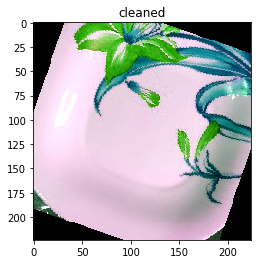

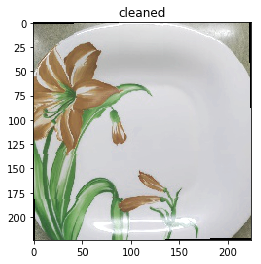

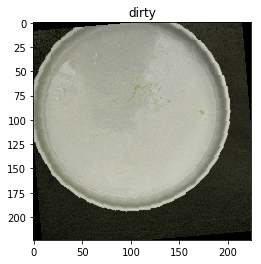

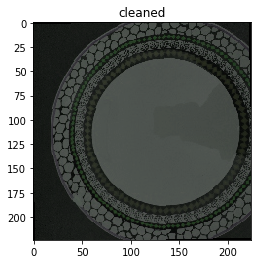

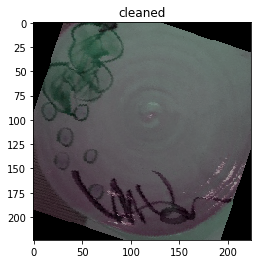

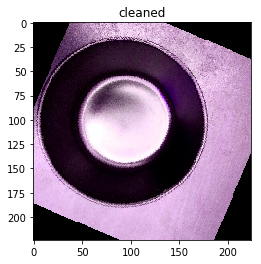

In [79]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [80]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [81]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.2)

In [82]:
train_model(model, loss, optimizer, scheduler, num_epochs=93)

Epoch 0/92:



100%|██████████| 4/4 [00:00<00:00,  5.71it/s]

train Loss: 0.9770 Acc: 0.5625



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

val Loss: 1.3239 Acc: 0.5000
Epoch 1/92:



100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

train Loss: 1.0386 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

val Loss: 1.0255 Acc: 0.5000
Epoch 2/92:



100%|██████████| 4/4 [00:00<00:00,  7.18it/s]

train Loss: 0.8090 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.8138 Acc: 0.6250
Epoch 3/92:



100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

train Loss: 0.6757 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

val Loss: 0.6291 Acc: 0.7500
Epoch 4/92:



100%|██████████| 4/4 [00:00<00:00,  4.02it/s]

train Loss: 0.5507 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.6725 Acc: 0.5000
Epoch 5/92:



100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

train Loss: 0.5158 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

val Loss: 0.6843 Acc: 0.6250
Epoch 6/92:



100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

train Loss: 0.4046 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.5732 Acc: 0.7500
Epoch 7/92:



100%|██████████| 4/4 [00:00<00:00,  7.39it/s]

train Loss: 0.4356 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

val Loss: 0.5686 Acc: 0.7500
Epoch 8/92:



100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

train Loss: 0.4391 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

val Loss: 0.5358 Acc: 0.7500
Epoch 9/92:



100%|██████████| 4/4 [00:00<00:00,  7.28it/s]

train Loss: 0.3630 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

val Loss: 0.5309 Acc: 0.7500
Epoch 10/92:



100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

train Loss: 0.4179 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

val Loss: 0.5550 Acc: 0.7500
Epoch 11/92:



100%|██████████| 4/4 [00:00<00:00,  6.95it/s]

train Loss: 0.3037 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

val Loss: 0.5719 Acc: 0.7500
Epoch 12/92:



100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

train Loss: 0.3792 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

val Loss: 0.5779 Acc: 0.7500
Epoch 13/92:



100%|██████████| 4/4 [00:00<00:00,  7.28it/s]

train Loss: 0.3031 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

val Loss: 0.5496 Acc: 0.7500
Epoch 14/92:



100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

train Loss: 0.3257 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

val Loss: 0.5602 Acc: 0.7500
Epoch 15/92:



100%|██████████| 4/4 [00:00<00:00,  7.35it/s]

train Loss: 0.4275 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

val Loss: 0.5238 Acc: 0.7500
Epoch 16/92:



100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

train Loss: 0.2812 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.5267 Acc: 0.7500
Epoch 17/92:



100%|██████████| 4/4 [00:00<00:00,  4.10it/s]

train Loss: 0.3188 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

val Loss: 0.5314 Acc: 0.7500
Epoch 18/92:



100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

train Loss: 0.3581 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

val Loss: 0.5284 Acc: 0.7500
Epoch 19/92:



100%|██████████| 4/4 [00:00<00:00,  7.08it/s]

train Loss: 0.2927 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

val Loss: 0.5408 Acc: 0.7500
Epoch 20/92:



100%|██████████| 4/4 [00:00<00:00,  6.87it/s]

train Loss: 0.2391 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

val Loss: 0.5466 Acc: 0.7500
Epoch 21/92:



100%|██████████| 4/4 [00:00<00:00,  7.16it/s]

train Loss: 0.3747 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

val Loss: 0.5504 Acc: 0.7500
Epoch 22/92:



100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

train Loss: 0.4160 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.5477 Acc: 0.7500
Epoch 23/92:



100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

train Loss: 0.3071 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

val Loss: 0.5351 Acc: 0.7500
Epoch 24/92:



100%|██████████| 4/4 [00:00<00:00,  6.64it/s]

train Loss: 0.3660 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

val Loss: 0.5432 Acc: 0.7500
Epoch 25/92:



100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

train Loss: 0.2878 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

val Loss: 0.5544 Acc: 0.7500
Epoch 26/92:



100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

train Loss: 0.3285 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.5400 Acc: 0.7500
Epoch 27/92:



100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

train Loss: 0.3378 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

val Loss: 0.5169 Acc: 0.7500
Epoch 28/92:



100%|██████████| 4/4 [00:00<00:00,  7.39it/s]

train Loss: 0.4056 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

val Loss: 0.5179 Acc: 0.7500
Epoch 29/92:



100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

train Loss: 0.4499 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.5219 Acc: 0.7500
Epoch 30/92:



100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

train Loss: 0.3672 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

val Loss: 0.5253 Acc: 0.7500
Epoch 31/92:



100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

train Loss: 0.3318 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

val Loss: 0.5352 Acc: 0.7500
Epoch 32/92:



100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

train Loss: 0.3418 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

val Loss: 0.5522 Acc: 0.7500
Epoch 33/92:



100%|██████████| 4/4 [00:00<00:00,  7.37it/s]

train Loss: 0.4345 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

val Loss: 0.5605 Acc: 0.7500
Epoch 34/92:



100%|██████████| 4/4 [00:00<00:00,  7.38it/s]

train Loss: 0.3173 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.5678 Acc: 0.7500
Epoch 35/92:



100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

train Loss: 0.2741 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

val Loss: 0.5496 Acc: 0.7500
Epoch 36/92:



100%|██████████| 4/4 [00:00<00:00,  6.46it/s]

train Loss: 0.3997 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

val Loss: 0.5491 Acc: 0.7500
Epoch 37/92:



100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

train Loss: 0.2974 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.5488 Acc: 0.7500
Epoch 38/92:



100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

train Loss: 0.3247 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

val Loss: 0.5406 Acc: 0.7500
Epoch 39/92:



100%|██████████| 4/4 [00:00<00:00,  6.83it/s]

train Loss: 0.3449 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.5375 Acc: 0.7500
Epoch 40/92:



100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

train Loss: 0.3017 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

val Loss: 0.5384 Acc: 0.7500
Epoch 41/92:



100%|██████████| 4/4 [00:00<00:00,  6.85it/s]

train Loss: 0.4430 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

val Loss: 0.5383 Acc: 0.7500
Epoch 42/92:



100%|██████████| 4/4 [00:00<00:00,  7.23it/s]

train Loss: 0.3596 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

val Loss: 0.5296 Acc: 0.7500
Epoch 43/92:



100%|██████████| 4/4 [00:00<00:00,  7.32it/s]

train Loss: 0.3581 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.5388 Acc: 0.7500
Epoch 44/92:



100%|██████████| 4/4 [00:00<00:00,  7.30it/s]

train Loss: 0.3237 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

val Loss: 0.5289 Acc: 0.7500
Epoch 45/92:



100%|██████████| 4/4 [00:00<00:00,  7.35it/s]

train Loss: 0.3467 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

val Loss: 0.5405 Acc: 0.7500
Epoch 46/92:



100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

train Loss: 0.3369 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

val Loss: 0.5545 Acc: 0.7500
Epoch 47/92:



100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

train Loss: 0.2737 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

val Loss: 0.5546 Acc: 0.7500
Epoch 48/92:



100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

train Loss: 0.3987 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

val Loss: 0.5595 Acc: 0.7500
Epoch 49/92:



100%|██████████| 4/4 [00:00<00:00,  6.94it/s]

train Loss: 0.2769 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

val Loss: 0.5631 Acc: 0.7500
Epoch 50/92:



100%|██████████| 4/4 [00:00<00:00,  4.54it/s]

train Loss: 0.2660 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

val Loss: 0.5657 Acc: 0.7500
Epoch 51/92:



100%|██████████| 4/4 [00:00<00:00,  7.11it/s]

train Loss: 0.3419 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

val Loss: 0.5792 Acc: 0.7500
Epoch 52/92:



100%|██████████| 4/4 [00:00<00:00,  4.51it/s]

train Loss: 0.4251 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

val Loss: 0.5633 Acc: 0.7500
Epoch 53/92:



100%|██████████| 4/4 [00:00<00:00,  6.80it/s]

train Loss: 0.3126 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

val Loss: 0.5670 Acc: 0.7500
Epoch 54/92:



100%|██████████| 4/4 [00:00<00:00,  7.01it/s]

train Loss: 0.3958 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

val Loss: 0.5752 Acc: 0.7500
Epoch 55/92:



100%|██████████| 4/4 [00:00<00:00,  7.19it/s]

train Loss: 0.2744 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

val Loss: 0.5605 Acc: 0.7500
Epoch 56/92:



100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

train Loss: 0.3301 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

val Loss: 0.5575 Acc: 0.7500
Epoch 57/92:



100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

train Loss: 0.4517 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

val Loss: 0.5724 Acc: 0.7500
Epoch 58/92:



100%|██████████| 4/4 [00:00<00:00,  6.50it/s]

train Loss: 0.3020 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

val Loss: 0.5464 Acc: 0.7500
Epoch 59/92:



100%|██████████| 4/4 [00:00<00:00,  6.59it/s]

train Loss: 0.2549 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

val Loss: 0.5460 Acc: 0.7500
Epoch 60/92:



100%|██████████| 4/4 [00:00<00:00,  7.29it/s]

train Loss: 0.3454 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

val Loss: 0.5524 Acc: 0.7500
Epoch 61/92:



100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

train Loss: 0.2179 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

val Loss: 0.5359 Acc: 0.7500
Epoch 62/92:



100%|██████████| 4/4 [00:00<00:00,  6.82it/s]

train Loss: 0.4362 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

val Loss: 0.5457 Acc: 0.7500
Epoch 63/92:



100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

train Loss: 0.3786 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

val Loss: 0.5399 Acc: 0.7500
Epoch 64/92:



100%|██████████| 4/4 [00:00<00:00,  7.28it/s]

train Loss: 0.3764 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

val Loss: 0.5361 Acc: 0.7500
Epoch 65/92:



100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

train Loss: 0.4036 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.5398 Acc: 0.7500
Epoch 66/92:



100%|██████████| 4/4 [00:00<00:00,  7.42it/s]

train Loss: 0.3057 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

val Loss: 0.5410 Acc: 0.7500
Epoch 67/92:



100%|██████████| 4/4 [00:00<00:00,  7.41it/s]

train Loss: 0.2904 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

val Loss: 0.5378 Acc: 0.7500
Epoch 68/92:



100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

train Loss: 0.2926 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

val Loss: 0.5334 Acc: 0.7500
Epoch 69/92:



100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

train Loss: 0.3370 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

val Loss: 0.5301 Acc: 0.7500
Epoch 70/92:



100%|██████████| 4/4 [00:00<00:00,  6.22it/s]

train Loss: 0.2734 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

val Loss: 0.5424 Acc: 0.7500
Epoch 71/92:



100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

train Loss: 0.2903 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

val Loss: 0.5375 Acc: 0.7500
Epoch 72/92:



100%|██████████| 4/4 [00:00<00:00,  6.80it/s]

train Loss: 0.2999 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

val Loss: 0.5443 Acc: 0.7500
Epoch 73/92:



100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

train Loss: 0.3319 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

val Loss: 0.5339 Acc: 0.7500
Epoch 74/92:



100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

train Loss: 0.3800 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

val Loss: 0.5451 Acc: 0.7500
Epoch 75/92:



100%|██████████| 4/4 [00:00<00:00,  6.97it/s]

train Loss: 0.3006 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

val Loss: 0.5415 Acc: 0.7500
Epoch 76/92:



100%|██████████| 4/4 [00:00<00:00,  6.90it/s]

train Loss: 0.3153 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

val Loss: 0.5455 Acc: 0.7500
Epoch 77/92:



100%|██████████| 4/4 [00:00<00:00,  6.51it/s]

train Loss: 0.2848 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

val Loss: 0.5336 Acc: 0.7500
Epoch 78/92:



100%|██████████| 4/4 [00:00<00:00,  5.99it/s]

train Loss: 0.3690 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

val Loss: 0.5510 Acc: 0.7500
Epoch 79/92:



100%|██████████| 4/4 [00:00<00:00,  6.99it/s]

train Loss: 0.3330 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

val Loss: 0.5570 Acc: 0.7500
Epoch 80/92:



100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

train Loss: 0.3526 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

val Loss: 0.5627 Acc: 0.7500
Epoch 81/92:



100%|██████████| 4/4 [00:00<00:00,  6.90it/s]

train Loss: 0.4089 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

val Loss: 0.5675 Acc: 0.7500
Epoch 82/92:



100%|██████████| 4/4 [00:00<00:00,  6.74it/s]

train Loss: 0.3001 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

val Loss: 0.5283 Acc: 0.7500
Epoch 83/92:



100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

train Loss: 0.3447 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

val Loss: 0.5614 Acc: 0.7500
Epoch 84/92:



100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

train Loss: 0.3094 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

val Loss: 0.5471 Acc: 0.7500
Epoch 85/92:



100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

train Loss: 0.2818 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

val Loss: 0.5357 Acc: 0.7500
Epoch 86/92:



100%|██████████| 4/4 [00:00<00:00,  7.10it/s]

train Loss: 0.2731 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

val Loss: 0.5386 Acc: 0.7500
Epoch 87/92:



100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

train Loss: 0.2398 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

val Loss: 0.5478 Acc: 0.7500
Epoch 88/92:



100%|██████████| 4/4 [00:00<00:00,  7.04it/s]

train Loss: 0.3907 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

val Loss: 0.5376 Acc: 0.7500
Epoch 89/92:



100%|██████████| 4/4 [00:00<00:00,  7.46it/s]

train Loss: 0.3146 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

val Loss: 0.5514 Acc: 0.7500
Epoch 90/92:



100%|██████████| 4/4 [00:00<00:00,  7.25it/s]

train Loss: 0.3259 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

val Loss: 0.5644 Acc: 0.7500
Epoch 91/92:



100%|██████████| 4/4 [00:00<00:00,  7.07it/s]

train Loss: 0.4132 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

val Loss: 0.5525 Acc: 0.7500
Epoch 92/92:



100%|██████████| 4/4 [00:00<00:00,  7.20it/s]

train Loss: 0.2501 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

val Loss: 0.5320 Acc: 0.7500


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [83]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [84]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [85]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [86]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)


100%|██████████| 93/93 [00:04<00:00, 23.02it/s]

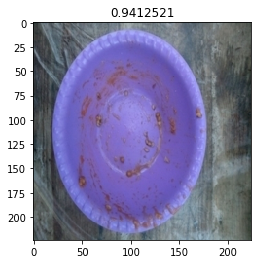

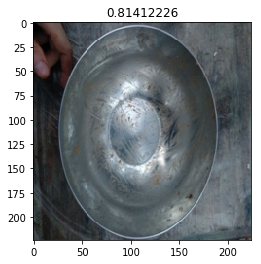

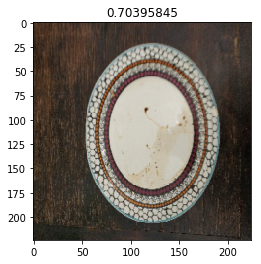

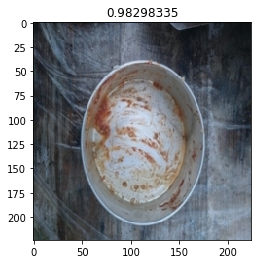

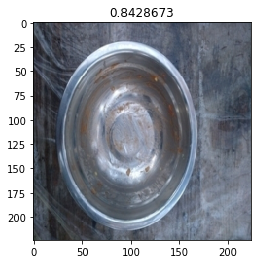

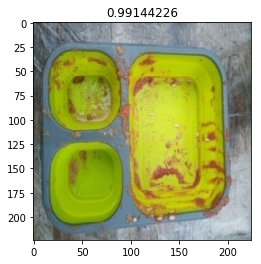

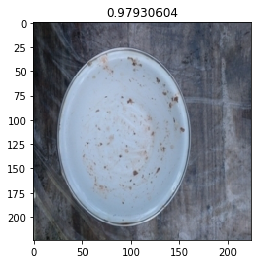

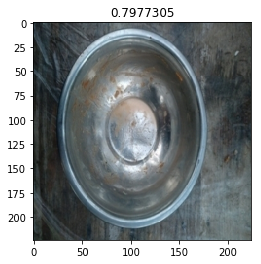

In [87]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [88]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [89]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.7 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [90]:
submission_df.to_csv('submission.csv')

In [36]:
!rm -rf train val test

In [91]:
submission_df

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,cleaned
0008,dirty
